## Playing around with XGBoost

Based on client info and marketing info, we want to classify if customer subscribes. 

## Step 1: Explore and prep data 

In [58]:
import pandas as pd
df = pd.read_csv('bank-additional-full.csv', delimiter=";")

In [59]:
display(df)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [60]:
# remove cols that we aren't interested in
cols_to_drop = ['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

df = df.drop(columns=cols_to_drop).rename(columns={'job': 'job_type', 'default': 'default_status', 'housing': 'housing_loan_status', 'loan': 'personal_loan_status', 'contact': 'contact_type', 'month': 'contact_month', 'day_of_week': 'contact_day_of_week', 'campaign': 'num_contacts', 'pdays': 'days_last_contact', 'previous': 'previous_contacts', 'poutcome': 'previous_outcome', 'y': 'result'})
df['result'] = df['result'].replace({'yes': 1, 'no': 0})

In [61]:
df.head()

,age,job_type,marital,education,default_status,housing_loan_status,personal_loan_status,contact_type,contact_month,contact_day_of_week,num_contacts,days_last_contact,previous_contacts,previous_outcome,result
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,0


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   41188 non-null  int64 
 1   job_type              41188 non-null  object
 2   marital               41188 non-null  object
 3   education             41188 non-null  object
 4   default_status        41188 non-null  object
 5   housing_loan_status   41188 non-null  object
 6   personal_loan_status  41188 non-null  object
 7   contact_type          41188 non-null  object
 8   contact_month         41188 non-null  object
 9   contact_day_of_week   41188 non-null  object
 10  num_contacts          41188 non-null  int64 
 11  days_last_contact     41188 non-null  int64 
 12  previous_contacts     41188 non-null  int64 
 13  previous_outcome      41188 non-null  object
 14  result                41188 non-null  int64 
dtypes: int64(5), object(10)
memory usage

In [63]:
df['result'].value_counts() # 0 is people who rejected offer, most of people

0    36548
1     4640
Name: result, dtype: int64

In [64]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='result')
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, # test should be 20% 
                                                    stratify = y, # keep the proportion of y values through the training and test sets
                                                    random_state = 8) # for reproducible result 

## Step 2: Build a pipeline for training

We build up a pipeline with sklearn.pipeline.Pipeline

In [65]:
!pip install category_encoders
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder 
from xgboost import XGBClassifier


estimators = [ 
    ('encoder', TargetEncoder()), # preproc procedure, transformed categorical features to numeric ones
    ('clf', XGBClassifier(random_state=8)) # we'd used XGBRegressor if we had a regression problem 
]

pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))])

## Step 3: Set hyperparameter tuning

In [66]:
!pip install scikit-optimize

In [67]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [68]:
# specify search space (i.e. type and ranges of hyperparameters)
# clf refers to sklearn classifier

search_space = {
    'clf__max_depth': Integer(2,8), # 
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'), # boosting learning rate, with log transform
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1),
    'clf__colsample_bylevel': Real(0.5,1),
    'clf__colsample_bynode': Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamme': Real(0.0, 10.0)
}

# obs, BayesSearchCV requires you to use a scikit-learn pipeline to ensure encoding of target is applied 
# to the correct dataset during cross-validation.

opt = BayesSearchCV(pipe, search_space, 
                        cv=3, 
                        n_iter=10, # number of hyperparam settings that are sampled
                        scoring='roc_auc', # metric for evaluation 
                        random_state=8)

## Step 4: Train the XGBoost Model

In [69]:
# opt includes both the pipeline and the hyper param tuning settings! 
opt.fit(X_train, y_train)

/work/EmmaRisgaardOlsen#9993/ds-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:14:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamme" } are not used.

  warnings.warn(smsg, UserWarning)
/work/EmmaRisgaardOlsen#9993/ds-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:14:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamme" } are not used.

  warnings.warn(smsg, UserWarning)
/work/EmmaRisgaardOlsen#9993/ds-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:14:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamme" } are not used.

  warnings.warn(smsg, UserWarning)
/work/EmmaRisgaardOlsen#9993/ds-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:14:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamme" } are not used.

  warnings.warn(smsg, UserWarning)
/work/EmmaRisgaardOlsen#9993/ds-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=N...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

## Step 5: Evaluate model and make predictions

In [70]:
opt.best_estimator_

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['job_type', 'marital', 'education',
                                     'default_status', 'housing_loan_status',
                                     'personal_loan_status', 'contact_type',
                                     'contact_month', 'contact_day_of_week',
                                     'previous_outcome'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.6854728136721551,
                               colsample_bynode=0.971629242155...
                               gamme=9.269342703724346, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.4165635668761467, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [71]:
opt.best_score_ 

0.7635098521847565

In [72]:
opt.score(X_test, y_test)

0.7800954644086986

In [73]:
opt.predict(X_test)

array([0, 0, 0, ..., 1, 0, 0])

In [74]:
opt.predict_proba(X_test)

array([[0.9478533 , 0.05214665],
       [0.9528535 , 0.04714652],
       [0.92085713, 0.07914288],
       ...,
       [0.4892112 , 0.5107888 ],
       [0.9711539 , 0.02884607],
       [0.92267805, 0.07732195]], dtype=float32)

## Step 6: Measure Feature importance

In [75]:
# extract the fitted XGBoost model
opt.best_estimator_.steps

[('encoder',
  TargetEncoder(cols=['job_type', 'marital', 'education', 'default_status',
                      'housing_loan_status', 'personal_loan_status',
                      'contact_type', 'contact_month', 'contact_day_of_week',
                      'previous_outcome'])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.6854728136721551,
                colsample_bynode=0.9716292421559054,
                colsample_bytree=0.9999681720272138, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                gamme=9.269342703724346, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.4165635668761467,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=None,
                min_child_weight

In [78]:
from xgboost import plot_importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

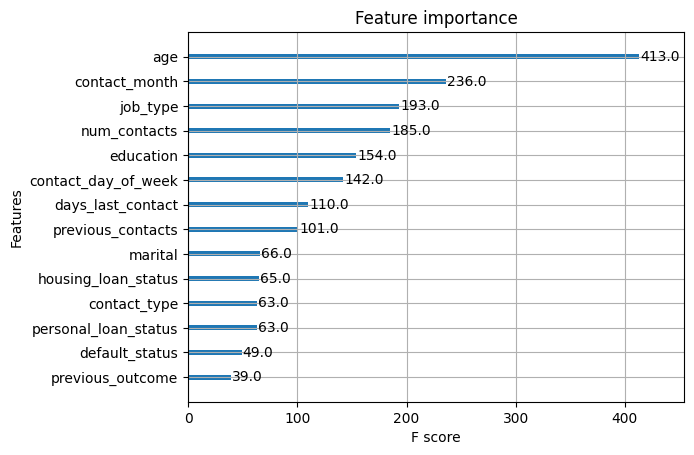

In [81]:
# plot feature importance: n of times each feature appears in a tree
xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)